## モデル構築、学習
VGG16をFine Tuningし、オリジナルの画像分類器を作成する。  
分類器では、ラーメン、うどん、蕎麦の分類を行う。

### 画像のディレクトリを設定

In [ ]:
# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# ディレクトリを設定する
data_dir="/content/drive/My Drive/image-classification/" # 自分のフォルダに書き換え。

In [ ]:
# 画像データセットのディレクトリを設定
imagepath=data_dir+"/dataset/"

### VGG16 Fine Tuning

In [ ]:
# tensorFlow のバージョン確認
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
# ライブラリのインポート
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint

import numpy as np
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

# model = VGG16()
# model.summary()

In [ ]:
# パラメータの設定
NUM_CATEGORIES = 3 # 分類数
IMAGE_SIZE = 224 # 画像サイズ
BATCH_SIZE = 16 # バッチサイズ
EPOC_SIZE = 100 # エポック数
NUM_TRAINING = 302 # 訓練データ数
NUM_VALIDATION = 111 # 検証データ数

#### VGG16を基にモデルの構築

In [ ]:
# VGG16をベースモデルに設定
input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

# FC層を構築
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(NUM_CATEGORIES, activation='softmax'))

# VGG16モデルにFC層を結合
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

# VGG16の図の青色の部分は重みを固定（frozen）
for layer in model.layers[:15]:
    layer.trainable = False

# 多クラス分類を指定
model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(lr=1e-3, momentum=0.9),
    metrics=['accuracy']
)

# ネットワークの確認
model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [ ]:
# 訓練データと検証データを生成するジェネレータを作成
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    imagepath+'train',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    imagepath+'validation',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
# 読み込み結果（画像数）が表示される

Found 302 images belonging to 3 classes.
Found 111 images belonging to 3 classes.


In [ ]:
# 学習
history = model.fit_generator(
    train_generator,
    steps_per_epoch=NUM_TRAINING//BATCH_SIZE,
    epochs=EPOC_SIZE,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=NUM_VALIDATION//BATCH_SIZE
)


Epoch 1/100
18/18 [==============================] - 5s 254ms/step - loss: 1.1821 - accuracy: 0.4685 - val_loss: 0.8741 - val_accuracy: 0.5208
Epoch 2/100
18/18 [==============================] - 4s 238ms/step - loss: 0.7645 - accuracy: 0.6643 - val_loss: 0.6713 - val_accuracy: 0.7292
Epoch 3/100
18/18 [==============================] - 4s 242ms/step - loss: 0.5575 - accuracy: 0.7657 - val_loss: 0.3826 - val_accuracy: 0.8438
Epoch 4/100
18/18 [==============================] - 4s 239ms/step - loss: 0.4421 - accuracy: 0.8462 - val_loss: 0.5298 - val_accuracy: 0.7708
Epoch 5/100
18/18 [==============================] - 4s 240ms/step - loss: 0.2935 - accuracy: 0.9056 - val_loss: 0.2921 - val_accuracy: 0.8854
Epoch 6/100
18/18 [==============================] - 4s 239ms/step - loss: 0.2178 - accuracy: 0.9091 - val_loss: 0.3843 - val_accuracy: 0.8333
Epoch 7/100
18/18 [==============================] - 4s 240ms/step - loss: 0.1596 - accuracy: 0.9545 - val_loss: 0.5616 - val_accuracy: 0.8021

### 学習結果の評価

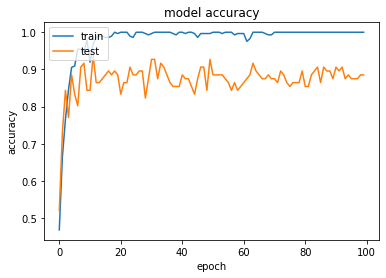

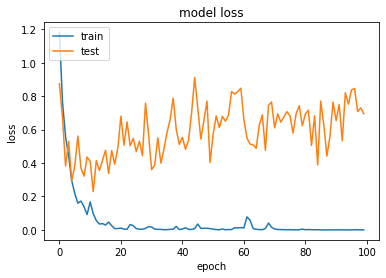

In [ ]:
# 精度の描画
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 誤差の描画
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# モデルを保存
model.save("image_classification_model.h5",include_optimizer=False)